<a href="https://colab.research.google.com/github/kaantopcu/2D_Breast_Cancer_Segmentation/blob/main/Breast_Cancer_Segmentation_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00


In [2]:
import torch
from PIL import Image
import requests
import numpy as np
from transformers import SamModel, SamProcessor
from datasets import load_dataset
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist,directed_hausdorff

# Load model and processor

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
medsam_processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")
medsam_model = SamModel.from_pretrained("wanglab/medsam-vit-base").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.52k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

# Load image + ground truth map

In [4]:
dataset = load_dataset("nielsr/breast-cancer", split="train")

Generating train split:   0%|          | 0/130 [00:00<?, ? examples/s]

In [5]:
idx = 10

# load image
sample_image = dataset[idx]

In [6]:
# load ground truth segmentation
sample_ground_truth_seg = np.array(sample_image["label"])
np.unique(sample_ground_truth_seg)

array([0, 1], dtype=int32)

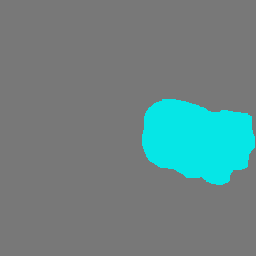

In [7]:
# a random color palette mapping each class to a color (RGB)
palette = [[120, 120, 120], [6, 230, 230]]

color_seg = np.zeros((sample_ground_truth_seg.shape[0], sample_ground_truth_seg.shape[1], 3), dtype=np.uint8) # height, width, 3

for label, color in enumerate(palette):
    color_seg[sample_ground_truth_seg == label, :] = color

Image.fromarray(color_seg)

# Load box prompt and predict

In [8]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

input_boxes = get_bounding_box(sample_ground_truth_seg)
input_boxes

[131, 86, 256, 201]

In [9]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

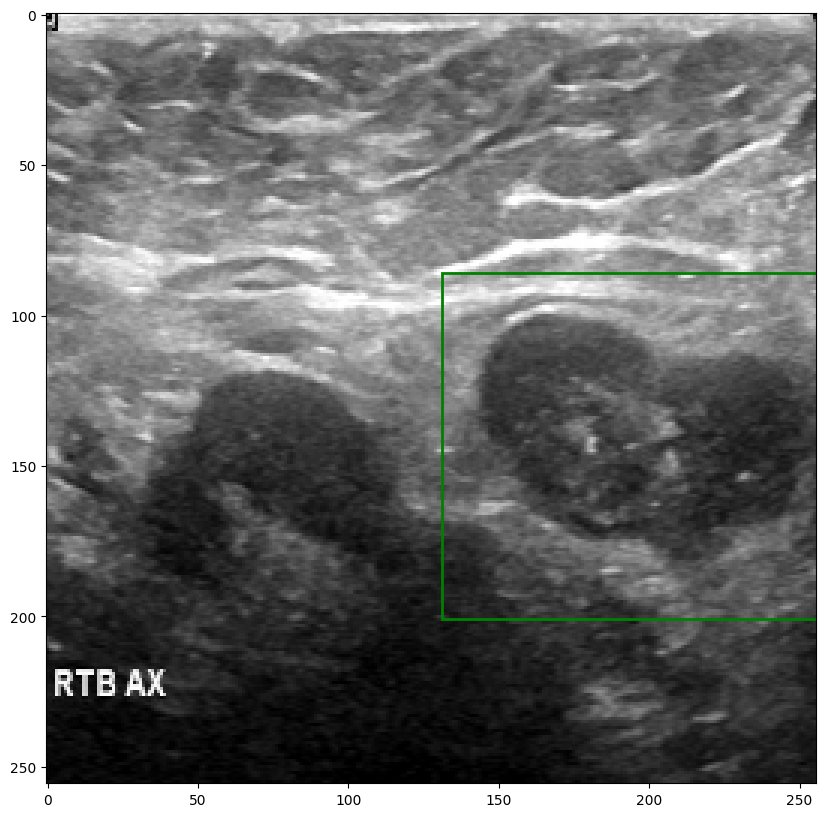

In [10]:
show_boxes_on_image(sample_image["image"], [input_boxes])

# Predictions

In [11]:
def inference(image,processor,model):
  ground_truth_seg = np.array(image["label"])
  input_boxes = get_bounding_box(ground_truth_seg)
  inputs = processor(image["image"], input_boxes=[[input_boxes]], return_tensors="pt").to(device)
 # for k,v in inputs.items():
 #   print(k,v.shape)
  model.to(device)

  # forward pass
# note that the authors use `multimask_output=False` when performing inference
  with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

  # apply sigmoid
  seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  # convert soft mask to hard mask
  seg_prob = seg_prob.cpu().numpy().squeeze()
  seg = (seg_prob > 0.5).astype(np.uint8)
  return seg

# Viusalize the results

In [12]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [13]:
medsam_seg_pred = inference(sample_image,medsam_processor,medsam_model)
sam_seg_pred = inference(sample_image,sam_processor,sam_model)

(-0.5, 255.5, 255.5, -0.5)

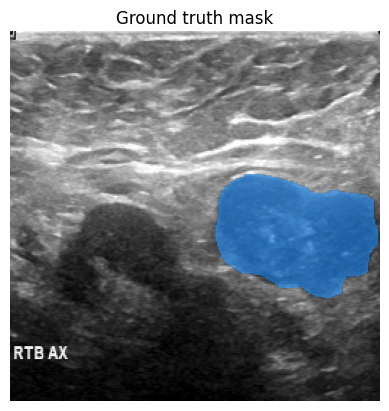

In [14]:
fig, axes = plt.subplots()

axes.imshow(np.array(sample_image["image"]))
show_mask(sample_ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

(-0.5, 255.5, 255.5, -0.5)

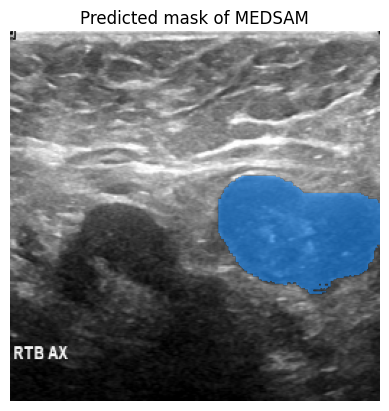

In [15]:
fig, axes = plt.subplots()

axes.imshow(np.array(sample_image["image"]))
show_mask(medsam_seg_pred, axes)
axes.title.set_text(f"Predicted mask of MEDSAM")
axes.axis("off")

(-0.5, 255.5, 255.5, -0.5)

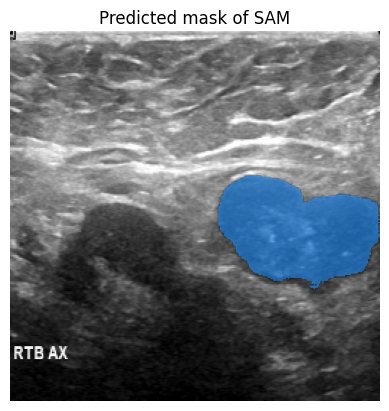

In [16]:
fig, axes = plt.subplots()

axes.imshow(np.array(sample_image["image"]))
show_mask(sam_seg_pred, axes)
axes.title.set_text(f"Predicted mask of SAM")
axes.axis("off")

# Performance Metrics

In [17]:
def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    if total_pixel_pred == 0:
      return 0.0  # Avoid division by zero
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    if total_pixel_truth == 0:
        return 0.0  # Avoid division by zero
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    if total_sum == 0:
        return 0.0  # Avoid division by zero
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places


def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    if union == 0:
        return 0.0  # Avoid division by zero
    iou = np.mean(intersect/union)
    return round(iou, 3)



def hausdorff_distance(true_segmentation, predicted_segmentation):
    true_surface = extract_surface(true_segmentation)
    predicted_surface = extract_surface(predicted_segmentation)

    if len(true_surface) == 0 or len(predicted_surface) == 0:
        return float('inf')  # Avoid division by zero

    hd_forward = directed_hausdorff(true_surface, predicted_surface)[0]
    hd_backward = directed_hausdorff(predicted_surface, true_surface)[0]

    hd = max(hd_forward, hd_backward)
    return round(hd, 3)


def average_symmetric_surface_distance(true_segmentation, predicted_segmentation):
    true_surface = extract_surface(true_segmentation)
    predicted_surface = extract_surface(predicted_segmentation)

    if len(true_surface) == 0 or len(predicted_surface) == 0:
        return float('inf')  # Avoid division by zero

    distances_true_to_pred = cdist(true_surface, predicted_surface, metric='euclidean')
    min_distances_true_to_pred = np.min(distances_true_to_pred, axis=1)

    distances_pred_to_true = cdist(predicted_surface, true_surface, metric='euclidean')
    min_distances_pred_to_true = np.min(distances_pred_to_true, axis=1)

    assd = (np.mean(min_distances_true_to_pred) + np.mean(min_distances_pred_to_true)) / 2.0
    return round(assd, 3)

def volumetric_similarity(groundtruth_mask, pred_mask):
    volume_true = np.sum(groundtruth_mask)
    volume_pred = np.sum(pred_mask)

    if volume_true + volume_pred == 0:
        return float('inf')  # Avoid division by zero

    vs = 1 - abs(volume_true - volume_pred) / (volume_true + volume_pred)
    return round(vs, 3)

def specificity(groundtruth_mask, pred_mask):
    true_negatives = np.sum((groundtruth_mask == 0) & (pred_mask == 0))
    false_positives = np.sum((groundtruth_mask == 0) & (pred_mask == 1))
    if true_negatives + false_positives == 0:
        return float('inf')  # Avoid division by zero
    specificity = true_negatives / (true_negatives + false_positives)
    return round(specificity, 3)


def matthews_corrcoef(groundtruth_mask, pred_mask):
    TP = np.sum((groundtruth_mask == 1) & (pred_mask == 1))
    TN = np.sum((groundtruth_mask == 0) & (pred_mask == 0))
    FP = np.sum((groundtruth_mask == 0) & (pred_mask == 1))
    FN = np.sum((groundtruth_mask == 1) & (pred_mask == 0))

    numerator = (TP * TN) - (FP * FN)
    denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    if denominator == 0:
        return float('inf')  # Avoid division by zero
    mcc = numerator / denominator
    return round(mcc, 3)

def extract_surface(segmentation):
    """ Extracts the surface points from a binary segmentation mask. """
    # Assuming segmentation is a binary mask where 1 is the structure and 0 is the background.
    surface_points = np.argwhere(segmentation)
    return surface_points

def calculate_diameter(points):
    """ Calculates the diameter of the set of points. """
    if len(points) == 0:
        return 0
    distances = cdist(points, points)
    diameter = np.max(distances)
    return diameter

def normalized_surface_distance(true_segmentation, predicted_segmentation):
    """ Calculates the Normalized Surface Distance (NSD) between two segmentations. """
    true_surface = extract_surface(true_segmentation)
    predicted_surface = extract_surface(predicted_segmentation)

    if len(true_surface) == 0 or len(predicted_surface) == 0:
        return float('inf')  # Avoid division by zero

    distances = cdist(true_surface, predicted_surface, metric='euclidean')
    min_distances = np.min(distances, axis=1)

    diameter = calculate_diameter(true_surface)
    if diameter == 0:
        return float('inf')  # Avoid division by zero

    nsd = np.mean(min_distances / diameter)
    return nsd

In [18]:
print("Precision: ", precision_score_(sample_ground_truth_seg,medsam_seg_pred))
print("Recall: ", recall_score_(sample_ground_truth_seg,medsam_seg_pred))
print("Accuracy: ", accuracy(sample_ground_truth_seg,medsam_seg_pred))
print("Dice Coefficient: ", dice_coef(sample_ground_truth_seg,medsam_seg_pred))
print("Jaccard Index: ", iou(sample_ground_truth_seg,medsam_seg_pred))
print("Hausdorff Distance: ", hausdorff_distance(sample_ground_truth_seg,medsam_seg_pred))
print("Average Symmetric Surface Distance: ", average_symmetric_surface_distance(sample_ground_truth_seg,medsam_seg_pred))
print("Volumetric Similarity: ", volumetric_similarity(sample_ground_truth_seg,medsam_seg_pred))
print("Specificity (True Negative Rate): ", specificity(sample_ground_truth_seg,medsam_seg_pred))
print("Matthews Correlation Coefficient: ", matthews_corrcoef(sample_ground_truth_seg,medsam_seg_pred))
print("Normalized Surface Distance: ", normalized_surface_distance(sample_ground_truth_seg,medsam_seg_pred))

Precision:  0.98
Recall:  0.929
Accuracy:  0.99
Dice Coefficient:  0.954
Jaccard Index:  0.911
Hausdorff Distance:  8.944
Average Symmetric Surface Distance:  0.11
Volumetric Similarity:  0.973
Specificity (True Negative Rate):  0.998
Matthews Correlation Coefficient:  0.948
Normalized Surface Distance:  0.0016097755266822691


In [19]:
print("Precision: ", precision_score_(sample_ground_truth_seg,sam_seg_pred))
print("Recall: ", recall_score_(sample_ground_truth_seg,sam_seg_pred))
print("Accuracy: ", accuracy(sample_ground_truth_seg,sam_seg_pred))
print("Dice Coefficient: ", dice_coef(sample_ground_truth_seg,sam_seg_pred))
print("Jaccard Index: ", iou(sample_ground_truth_seg,sam_seg_pred))
print("Hausdorff Distance: ", hausdorff_distance(sample_ground_truth_seg,sam_seg_pred))
print("Average Symmetric Surface Distance: ", average_symmetric_surface_distance(sample_ground_truth_seg,sam_seg_pred))
print("Volumetric Similarity: ", volumetric_similarity(sample_ground_truth_seg,sam_seg_pred))
print("Specificity (True Negative Rate): ", specificity(sample_ground_truth_seg,sam_seg_pred))
print("Matthews Correlation Coefficient: ", matthews_corrcoef(sample_ground_truth_seg,sam_seg_pred))
print("Normalized Surface Distance: ", normalized_surface_distance(sample_ground_truth_seg,sam_seg_pred))

Precision:  0.992
Recall:  0.852
Accuracy:  0.983
Dice Coefficient:  0.916
Jaccard Index:  0.846
Hausdorff Distance:  12.649
Average Symmetric Surface Distance:  0.273
Volumetric Similarity:  0.924
Specificity (True Negative Rate):  0.999
Matthews Correlation Coefficient:  0.91
Normalized Surface Distance:  0.004621511717975229


In [20]:
def compute_average_metrics(groundtruth_masks, pred_masks):
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    dice_scores = []
    iou_scores = []
    hausdorff_scores = []
    assd_scores = []
    vs_scores = []
    specificity_scores = []
    mcc_socres = []
    nsd_scores = []

    for groundtruth_mask, pred_mask in zip(groundtruth_masks, pred_masks):
        precision_scores.append(precision_score_(groundtruth_mask, pred_mask))
        recall_scores.append(recall_score_(groundtruth_mask, pred_mask))
        accuracy_scores.append(accuracy(groundtruth_mask, pred_mask))
        dice_scores.append(dice_coef(groundtruth_mask, pred_mask))
        iou_scores.append(iou(groundtruth_mask, pred_mask))
        hausdorff_scores.append(hausdorff_distance(groundtruth_mask, pred_mask))
        assd_scores.append(average_symmetric_surface_distance(groundtruth_mask, pred_mask))
        vs_scores.append(volumetric_similarity(groundtruth_mask, pred_mask))
        specificity_scores.append(specificity(groundtruth_mask, pred_mask))
        mcc_socres.append(matthews_corrcoef(groundtruth_mask, pred_mask))
        nsd_scores.append(normalized_surface_distance(groundtruth_mask, pred_mask))



    average_metrics = {
        'Precision': round(np.mean(precision_scores), 3),
        'Recall': round(np.mean(recall_scores), 3),
        'Accuracy': round(np.mean(accuracy_scores), 3),
        'Dice Coefficient': round(np.mean(dice_scores), 3),
        'Jaccard Index': round(np.mean(iou_scores), 3),
        'Hausdorff Distance': round(np.mean(hausdorff_scores), 3),
        'Average Symmetric Surface Distance': round(np.mean(assd_scores), 3),
        'Volumetric Similarity (VS)': round(np.mean(vs_scores), 3),
        'Specificity (True Negative Rate)': round(np.mean(specificity_scores), 3),
        'Matthews Correlation Coefficient': round(np.mean(mcc_socres), 3),
        'Normalized Surface Distance': round(np.mean(nsd_scores), 3)

    }

    return average_metrics

In [21]:
medsam_seg_pred = inference(sample_image,medsam_processor,medsam_model)
sam_seg_pred = inference(sample_image,sam_processor,sam_model)

In [22]:
groundtruth_masks = [np.array(dataset[i]["label"]) for i in range(130)]
medsam_seg_masks = [inference(dataset[i],medsam_processor,medsam_model) for i in range(130)]
sam_seg_masks = [inference(dataset[i],sam_processor,sam_model) for i in range(130)]

KeyboardInterrupt: 

In [ ]:
average_metrics = compute_average_metrics(groundtruth_masks, medsam_seg_masks)
print(average_metrics)

In [ ]:
average_metrics

In [ ]:
average_metrics = compute_average_metrics(groundtruth_masks, sam_seg_masks)
print(average_metrics)

In [ ]:
average_metrics